In [155]:
import numpy as np
import pandas as pd
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn.utils.rnn import pad_sequence
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import torch.optim as optim
import torchdata.datapipes as dp
import torchtext.transforms as T
import spacy
from torchtext.vocab import build_vocab_from_iterator
from torch.nn.utils.rnn import pad_sequence
from tqdm import tqdm, trange
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import torch.nn.functional as F
import gensim.downloader as api
from gensim.models import KeyedVectors
import math

# Transformer for sentimen analysis
### Our task is to convert tweet sentences into tokenizations and then convert the tokenizations into vectors representing the individual indices for each token in our vocabolary
### We use a transformer model with embedding layer (50 weights), positional embedding, multihead attention mechansim and layer norm
### We update the weights to train our model for classification of three different targets [neutral, positive, negative]

In [156]:
tweets = pd.read_csv('/kaggle/input/twitter-airline-sentiment/Tweets.csv')
device = 'cuda' if torch.cuda.is_available() else 'cpu'
texts = tweets['text']
labels = tweets['airline_sentiment']
tweets = pd.DataFrame(list(zip(texts, labels)), columns=['texts', 'labels'])
tweets

,texts,labels
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
...,...,...
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative
14637,@AmericanAir Please bring American Airlines to...,neutral
14638,"@AmericanAir you have my money, you change my ...",negative


## Exploratory Data Analysis

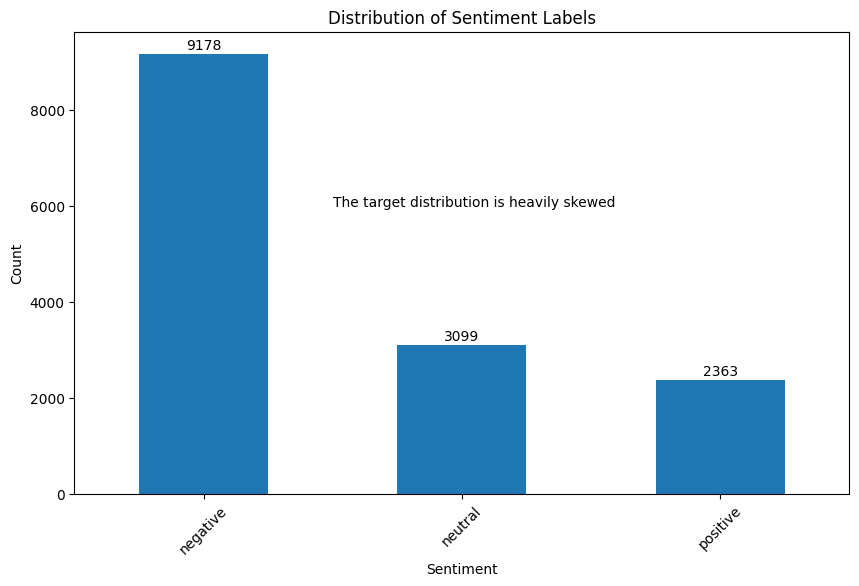

In [157]:
# Count occurrences of each label
label_counts = tweets['labels'].value_counts()

# Plot the distribution
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Count')

# Annotate the plot
for i, count in enumerate(label_counts):
    plt.text(i, count + 100, str(count), ha='center')

plt.annotate('The target distribution is heavily skewed', (0.5, 6000))
plt.xticks(rotation=45)
plt.show()

### Spacy is usedd for tokenizing english sentences 

In [158]:
eng = spacy.load("en_core_web_sm") 

def engTokenize(text):
    """
    Tokenize an English text and return a list of tokens
    """
    return [token.text for token in eng.tokenizer(text)]

### * We convert every letter to lower case
### * We remove special characters
### * We remove stopwords which have little sentimen 
### * We tokenize the sentences

In [159]:
def preprocess(tweets):
    # Lowercase the text
    tweets['texts'] = tweets['texts'].apply(lambda x: x.lower())
    
    # Remove special characters
    tweets['texts'] = tweets['texts'].apply(lambda x: ''.join(char.replace('@','') for char in x))
    
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tweets['texts'] = tweets['texts'].apply(lambda x: ' '.join(word for word in word_tokenize(x) if word.lower() not in stop_words))
    
    # Tokenize the words
    tweets['tokenized_texts'] = tweets['texts'].apply(engTokenize)
    
    return tweets

# Label encode targets
label_encoder = LabelEncoder()
tweets['labels'] = label_encoder.fit_transform(tweets['labels'])
tweets = preprocess(tweets)

## We create our vocabolary and create a dictionary to store the indices for each token in our vocabolary

In [160]:
t = []  # Initialize an empty list to store all words
for text in tweets['tokenized_texts']:
    text 
    t.extend(text)  # Extend the list with individual words instead of appending the whole split text

t = set(t)  # Convert the list to a set to get unique words
word_to_idx = {word: i for i, word in enumerate(t)}  # Create word-to-index mapping
print("Length of vocabulary:", len(word_to_idx))

Length of vocabulary: 15942


In [161]:
tweets

,texts,labels,tokenized_texts
0,virginamerica dhepburn said .,1,"[virginamerica, dhepburn, said, .]"
1,virginamerica plus 've added commercials exper...,2,"[virginamerica, plus, ', ve, added, commercial..."
2,virginamerica n't today ... must mean need tak...,1,"[virginamerica, n't, today, ..., must, mean, n..."
3,virginamerica 's really aggressive blast obnox...,0,"[virginamerica, 's, really, aggressive, blast,..."
4,virginamerica 's really big bad thing,0,"[virginamerica, 's, really, big, bad, thing]"
...,...,...,...
14635,americanair thank got different flight chicago .,2,"[americanair, thank, got, different, flight, c..."
14636,americanair leaving 20 minutes late flight . w...,0,"[americanair, leaving, 20, minutes, late, flig..."
14637,americanair please bring american airlines # b...,1,"[americanair, please, bring, american, airline..."
14638,"americanair money , change flight , n't answer...",0,"[americanair, money, ,, change, flight, ,, n't..."


## We split our data in train and val data. We then convert the train tokens into vectors representing the respective tokens corresponding indices from our vocabolary and initialize our dataloaders

In [162]:
# Split the data into training and validation sets
train_texts, val_texts, train_labels, val_labels = train_test_split(tweets['tokenized_texts'], tweets['labels'], test_size=0.2)

# Convert text tokens to indices using the vocabulary mapping
train_texts_indices = [[word_to_idx[word] for word in text if word in word_to_idx] for text in train_texts]
val_texts_indices = [[word_to_idx[word] for word in text if word in word_to_idx] for text in val_texts]


# Define the maximum sequence length
max_seq_length = 50  # You can adjust this based on your needs

# Pad sequences for training data
train_texts_indices_padded = [torch.tensor(sequence[:max_seq_length]) if len(sequence) >= max_seq_length else torch.cat((torch.tensor(sequence), torch.zeros(max_seq_length - len(sequence), dtype=torch.long))) for sequence in train_texts_indices]

# Pad sequences for validation data
val_texts_indices_padded = [torch.tensor(sequence[:max_seq_length]) if len(sequence) >= max_seq_length else torch.cat((torch.tensor(sequence), torch.zeros(max_seq_length - len(sequence), dtype=torch.long))) for sequence in val_texts_indices]

# Convert the padded sequences to PyTorch tensors
train_texts_indices_tensor = pad_sequence(train_texts_indices_padded, batch_first=True)
val_texts_indices_tensor = pad_sequence(val_texts_indices_padded, batch_first=True)

In [163]:
# Convert labels to PyTorch tensors
train_labels_tensor = torch.tensor(train_labels.values)
val_labels_tensor = torch.tensor(val_labels.values)

# Create TensorDataset objects
train_dataset = TensorDataset(train_texts_indices_tensor, train_labels_tensor)
val_dataset = TensorDataset(val_texts_indices_tensor, val_labels_tensor)

# Define batch size
batch_size = 32

# Create DataLoader objects
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# We instantiate our Transformer with embedding, positional embedding, multihead attention mechanism and layer norm

In [164]:
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(PositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:, :x.size(1)]


class TransformerEncoder(nn.Module):
    def __init__(self, vocab_size, embed_size, heads, num_layers, max_seq_length, dropout, num_classes):
        super(TransformerEncoder, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.positional_encoding = PositionalEncoding(embed_size, max_seq_length)
        self.encoder_layers = nn.ModuleList([
            nn.TransformerEncoderLayer(embed_size, heads, dropout=dropout)
            for _ in range(num_layers)
        ])
        self.norm = nn.LayerNorm(embed_size)
        self.fc = nn.Linear(embed_size, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        x = self.positional_encoding(x)
        
        for layer in self.encoder_layers:
            x = layer(x)
            x = self.norm(x)
        
        x = torch.mean(x, dim=1)
        return self.fc(x)


In [165]:
# Define hyperparameters
vocab_size = len(word_to_idx)  # Size of the vocabulary
embed_size = 50  # Embedding dimensionality
max_seq_length = 50  # Maximum sequence length
heads = 2  # Number of attention heads
num_layers = 2  # Number of Transformer encoder layers
dropout = 0.1  # Dropout rate
num_classes = 3  # Number of output classes for sentiment classification

In [166]:
# Initialize and train the model
model = TransformerEncoder(vocab_size, embed_size, heads, num_layers, max_seq_length, dropout, num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

## We train our model

100%|██████████| 366/366 [00:51<00:00,  7.12it/s]


Epoch 1/10, Train Loss: 0.8737, Train Accuracy: 0.6331, Val Loss: 0.8116, Val Accuracy: 0.6530


100%|██████████| 366/366 [00:51<00:00,  7.08it/s]


Epoch 2/10, Train Loss: 0.7490, Train Accuracy: 0.6864, Val Loss: 0.7156, Val Accuracy: 0.6889


100%|██████████| 366/366 [00:51<00:00,  7.07it/s]


Epoch 3/10, Train Loss: 0.6581, Train Accuracy: 0.7369, Val Loss: 0.6596, Val Accuracy: 0.7339


100%|██████████| 366/366 [00:52<00:00,  6.96it/s]


Epoch 4/10, Train Loss: 0.5801, Train Accuracy: 0.7682, Val Loss: 0.6088, Val Accuracy: 0.7497


100%|██████████| 366/366 [00:52<00:00,  6.92it/s]


Epoch 5/10, Train Loss: 0.5163, Train Accuracy: 0.7954, Val Loss: 0.6433, Val Accuracy: 0.7370


100%|██████████| 366/366 [00:52<00:00,  6.93it/s]


Epoch 6/10, Train Loss: 0.4644, Train Accuracy: 0.8217, Val Loss: 0.6136, Val Accuracy: 0.7572


100%|██████████| 366/366 [00:51<00:00,  7.09it/s]


Epoch 7/10, Train Loss: 0.4159, Train Accuracy: 0.8432, Val Loss: 0.5945, Val Accuracy: 0.7616


100%|██████████| 366/366 [00:51<00:00,  7.05it/s]


Epoch 8/10, Train Loss: 0.3775, Train Accuracy: 0.8577, Val Loss: 0.6106, Val Accuracy: 0.7746


100%|██████████| 366/366 [00:51<00:00,  7.11it/s]


Epoch 9/10, Train Loss: 0.3405, Train Accuracy: 0.8732, Val Loss: 0.6423, Val Accuracy: 0.7486


100%|██████████| 366/366 [00:51<00:00,  7.16it/s]


Epoch 10/10, Train Loss: 0.3050, Train Accuracy: 0.8891, Val Loss: 0.6550, Val Accuracy: 0.7674


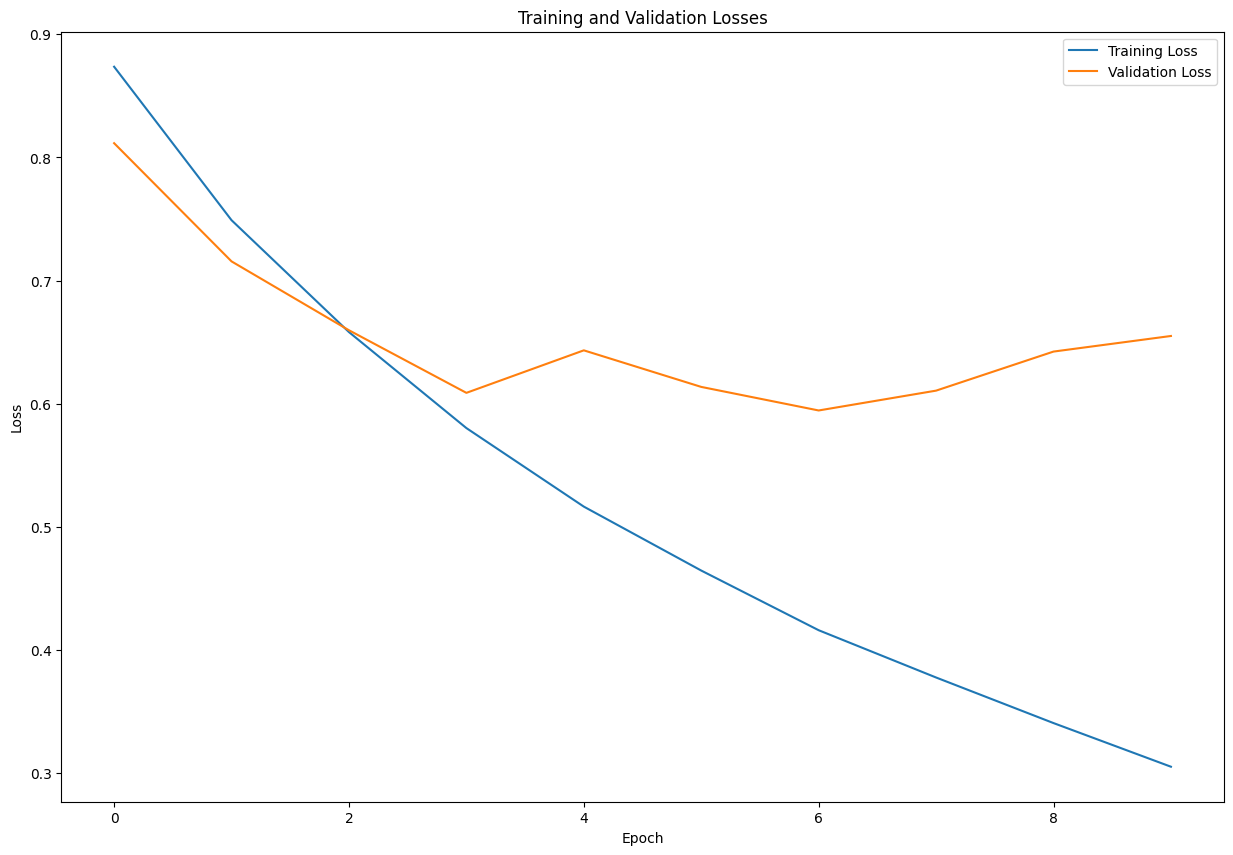

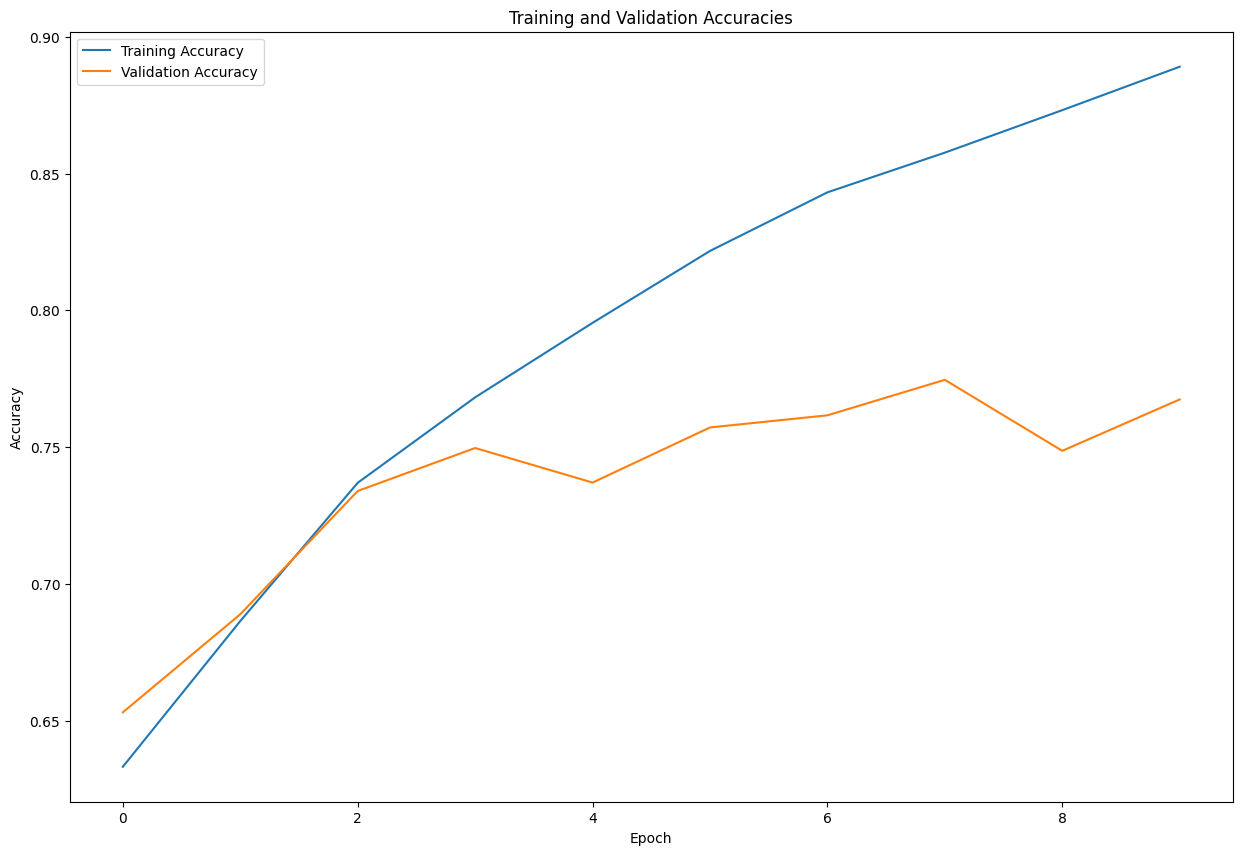

In [167]:
train_losses = []        # List to store training losses
val_losses = []          # List to store validation losses
train_accuracies = []    # List to store training accuracies
val_accuracies = []      # List to store validation accuracies

# Training loop
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    correct_train_preds = 0
    total_train_preds = 0
    for inputs, labels in tqdm(train_loader):
        optimizer.zero_grad()
        inputs, labels = inputs.to(device), labels.to(device)
        inputs = inputs.long()
        
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * inputs.size(0)
        
        _, predicted_train = torch.max(outputs, 1)
        correct_train_preds += (predicted_train == labels).sum().item()
        total_train_preds += labels.size(0)
        
    train_loss /= len(train_loader.dataset)
    train_losses.append(train_loss)
    
    train_accuracy = correct_train_preds / total_train_preds
    train_accuracies.append(train_accuracy)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    correct_val_preds = 0
    total_val_preds = 0
    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            inputs = inputs.long()
            
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            
            _, predicted_val = torch.max(outputs, 1)
            correct_val_preds += (predicted_val == labels).sum().item()
            total_val_preds += labels.size(0)
            
    val_loss /= len(val_loader.dataset)
    val_losses.append(val_loss)
    
    val_accuracy = correct_val_preds / total_val_preds
    val_accuracies.append(val_accuracy)
    
    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')
    
# Create DataFrame for plotting
loss_df = pd.DataFrame({'Train Loss': train_losses, 'Validation Loss': val_losses, 'Train Accuracy': train_accuracies, 'Validation Accuracy': val_accuracies})

# Plot the training and validation losses
plt.figure(figsize=(15, 10))
plt.plot(loss_df['Train Loss'], label='Training Loss')
plt.plot(loss_df['Validation Loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Losses')
plt.legend()
plt.show()

# Plot the training and validation accuracies
plt.figure(figsize=(15, 10))
plt.plot(loss_df['Train Accuracy'], label='Training Accuracy')
plt.plot(loss_df['Validation Accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracies')
plt.legend()
plt.show()

# Inference
### We test our models ability to predict the class of a sentence

In [169]:
stop_words = set(stopwords.words('english'))
# 1. Prepare Input Data
def preprocess_input(text):
    text = text.lower()
    text = ''.join(char.replace('@', '') for char in text)
    text = ' '.join(word for word in word_tokenize(text) if word.lower() not in stop_words)
    tokens = engTokenize(text)
    indexed_tokens = [word_to_idx[word] for word in tokens if word in word_to_idx]
    indexed_tokens_padded = torch.tensor(indexed_tokens[:max_seq_length], dtype=torch.long) if len(indexed_tokens) >= max_seq_length else torch.cat((torch.tensor(indexed_tokens, dtype=torch.long), torch.zeros(max_seq_length - len(indexed_tokens), dtype=torch.long)))
    return indexed_tokens_padded.unsqueeze(0)  # Add batch dimension

# Example input text
input_text = "hate us all"

# Preprocess input data
input_tensor = preprocess_input(input_text)

# 2. Convert to PyTorch Tensor
input_tensor = input_tensor.to(device)

# 3. Pass Through Model
model.eval()
with torch.no_grad():
    output = model(input_tensor)

# 4. Extract Predictions
predicted_class = torch.argmax(output, dim=1).item()

# Convert predicted class to sentiment label
predicted_sentiment = label_encoder.inverse_transform([predicted_class])[0]
print("Predicted Sentiment:", predicted_sentiment)


Predicted Sentiment: negative
